
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [ ]:
# I first use age and occupation, r2 is 0.26, then add labor, to 0.31(linear), 0.36 (random forest). Then add house. to 0.35(linear), rf 0.52? add marriage(0.375), rf 0.65

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
# of no use
marriage = pd.read_csv('Data/h27_marriage_df.csv', index_col=0)
marriage.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1,
         inplace=True)
marriage.replace('-', 0, inplace=True)
marriage.replace('X', 0, inplace=True)
marriage = marriage.apply(pd.to_numeric)
marriage = marriage.groupby('district_id').sum()
marriage1 = marriage[['unmarried', 'married', 'divorced']]
marriage1.head()

,unmarried,married,divorced
district_id,,,
1101,215837,298933,79513
1102,220379,395751,98382
1103,201438,362573,98283
1104,164786,281855,80510
1105,179900,298926,80721


In [41]:
# ignore, partly represented by job
# industry = pd.read_csv('Data/h27_indusry_df.csv', index_col=0)
# industry.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
# industry.head()

,A_agriculture_forestry_male,agriculture_male,B_fishing_male,C_mining_male,D_construction_male,E_manufacturing_male,F_Electricity_male,G_information_male,H_transport_male,I_wholesale_male,...,K_real_estate_female,L_academic_female,M_accommodation_female,N_entertainment_female,O_education_female,P_health_care_female,Q_service_female,R_other_service_female,S_public_services_female,T_other_female
district_id,,,,,,,,,,,,,,,,,,,,,
43101,306,264,6,2,3296,3683,419,1636,1773,6676,...,1127,1335,3898,2150,3058,9432,275,2841,1391,1989
43101,-,-,-,-,-,-,-,1,-,3,...,3,-,4,2,-,2,-,2,-,1
43101,-,-,-,-,1,7,-,5,2,7,...,2,1,4,2,5,6,-,2,2,1
43101,33,32,-,-,350,270,31,123,131,594,...,75,99,223,132,240,777,20,201,93,108
43101,-,-,-,-,11,17,1,18,6,64,...,11,10,21,15,21,62,2,19,10,10


In [40]:
# ignore, family cannot influence income
# family = pd.read_csv('Data/h27_family_df.csv',index_col=0)
# family.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
# family.head()

,family_count,family_member_count,general_family_count,member_1,member_2,member_3,member_4,member_5,member_6,member_7
district_id,,,,,,,,,,
25201,136153,340973,135957,39153,39186,25980,22117,7034,1830,657
25201,19,38,19,8,7,1,2,1,-,-
25201,10,17,10,5,4,-,1,-,-,-
25201,15,31,15,7,4,3,-,-,-,1
25201,22,38,22,11,8,1,2,-,-,-


In [28]:
# more labor will not result in higher average income, I quit this 
# but i find my r2 is too low and tried again, it raises from 0.26 to 0.31, not too much
labor = pd.read_csv('Data/h27_labor_df.csv', index_col=0)
labor.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1,
         inplace=True)
labor.replace('-', 0, inplace=True)
labor.replace('X', 0, inplace=True)
labor = labor.apply(pd.to_numeric)
labor = labor.groupby('district_id').sum()
labor.head()

,labor_male,no_labor_male,labor_female,no_labor_female
district_id,,,,
1101,171065,62135,152601,143631
1102,212414,97659,172779,185812
1103,201025,84843,161151,166589
1104,162740,58508,135152,121007
1105,164365,65949,141135,138351


In [29]:
# ignore, the same reason as house 
# house_info = pd.read_csv('Data/h27_house_info_df.csv', index_col=0)
# house_info.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
# house_info.head()

In [47]:
# ignore, the outcome of income, not cause
house = pd.read_csv('Data/h27_house_df.csv', index_col=0)
house.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
house.replace('-', 0, inplace=True)
house.replace('X', 0, inplace=True)
house = house.apply(pd.to_numeric)
house = house.groupby('district_id').sum()
house['family_house'] = house.iloc[:, 0:2].sum(axis=1)
house['family_rent'] = house.iloc[:, 2:7].sum(axis=1)
house['individual_house'] = house.iloc[:, 7:8].sum(axis=1)
house['individual_rent'] = house.iloc[:, 8:13].sum(axis=1)
house1=house[['family_house', 'individual_house', 'family_rent', 'individual_rent']]
house1.head()

,family_house,individual_house,family_rent,individual_rent
district_id,,,,
1101,551572,340099,238294,349430
1102,602699,515552,193899,314311
1103,525070,385291,218956,377668
1104,431916,287036,193444,325428
1105,468476,328879,191338,313999


In [9]:
# ignore
# status = pd.read_csv('Data/h27_work_status_df.csv', index_col=0)
# status.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1,
#          inplace=True)
# status.head()

In [10]:
income = pd.read_csv('Data/income_district.csv', index_col=0)
income.index.name = 'district_id'
income.head()

,income_mean
district_id,
13228,480.984419
43514,439.775281
23237,487.507769
18208,505.495103
12238,385.423846


In [11]:
age= pd.read_csv('Data/h27_age_df.csv', index_col=0)
age.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
age = age.iloc[:, 0:19]
age.replace('-', 0, inplace=True)
age.replace('X', 0, inplace=True)
age = age.apply(pd.to_numeric)
age = age.groupby('district_id').sum()
age['10-24'] = age.iloc[:, 0:3].sum(axis=1)
age['25-65'] = age.iloc[:, 3:10].sum(axis=1)
age['65-100'] = age.iloc[:, 10:18].sum(axis=1)
age1 = age[['10-24','25-65','65-100']]
age1.head()

,10-24,25-65,65-100
district_id,,,
1101,93929,367568,193104
1102,131047,376469,265375
1103,108694,372350,236721
1104,79630,311448,183211
1105,88274,321206,196055


In [12]:
# temporily do not use
# gender = pd.read_csv('Data/h27_gender_df2.csv', index_col=0)
# gender.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
# gender.replace('-', 0, inplace=True)
# gender.replace('X', 0, inplace=True)
# gender.drop('family_count', axis=1, inplace=True)
# gender = gender.apply(pd.to_numeric)
# gender = gender.groupby('district_id').sum()
# gender.drop('population', axis=1, inplace=True)
# gender.head()

In [13]:
job = pd.read_csv('Data/h27_job_df.csv', index_col=0)
job.drop(['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'], axis=1, inplace=True)
job.replace('-', 0, inplace=True)
job.replace('X', 0, inplace=True)
job = job.apply(pd.to_numeric)
job = job.groupby('district_id').sum()
job['advanced_male'] = age.iloc[:, 0:3].sum(axis=1)
job['service_male'] = age.iloc[:, 3:5].sum(axis=1)
job['basic_male'] = age.iloc[:, 5:12].sum(axis=1)
job['advanced_female'] = age.iloc[:, 12:15].sum(axis=1)
job['service_female'] = age.iloc[:, 12:15].sum(axis=1)
job['basic_female'] = age.iloc[:, 15:22].sum(axis=1)
job1 = job[['advanced_male','service_male','basic_male', 'advanced_female', 'service_female', 'basic_female']]
job1.head()

,advanced_male,service_male,basic_male,advanced_female,service_female,basic_female
district_id,,,,,,
1101,93929,102595,352935,81292,81292,678827
1102,131047,92209,409661,112563,112563,800611
1103,108694,97668,386695,100226,100226,742543
1104,79630,84233,311737,79798,79798,593416
1105,88274,88850,320061,86066,86066,628068


In [14]:
dataset = pd.concat([age1, job1], axis=1)

In [61]:
merged = pd.merge(income, dataset, on='district_id')
merged = pd.merge(merged, labor, on='district_id')
merged = pd.merge(merged, house1, on='district_id')
merged = pd.merge(merged, marriage1, on='district_id')
merged.head()

,income_mean,10-24,25-65,65-100,advanced_male,service_male,basic_male,advanced_female,service_female,basic_female,...,no_labor_male,labor_female,no_labor_female,family_house,individual_house,family_rent,individual_rent,unmarried,married,divorced
district_id,,,,,,,,,,,,,,,,,,,,,
13228,480.984419,27715,79480,63145,27715,17364,88332,30342,30342,177038,...,21455,34850,37978,124769,148287,17921,34450,42138,95724,18507
43514,439.775281,3522,11266,13446,3522,2438,14206,5906,5906,30420,...,3834,7878,6704,18928,24746,2160,5282,5112,16058,5520
23237,487.507769,29662,89979,61769,29662,20718,96345,30631,30631,185512,...,22127,42815,40391,130499,154424,23330,44866,44212,104104,21186
18208,505.495103,9627,30417,28751,9627,7137,35750,12189,12189,72924,...,8787,18881,16006,45189,62363,5639,9491,15809,38135,11565
12238,385.423846,8094,28608,35704,8094,5954,36832,16388,16388,77614,...,12614,15646,20072,54816,66350,4424,8592,15798,41138,12200


In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scatterd_1 =  scaler.fit_transform(merged[["10-24"]])
scatterd_2 =  scaler.fit_transform(merged[["25-65"]])
scatterd_3 =  scaler.fit_transform(merged[["65-100"]])
scatterd_4 =  scaler.fit_transform(merged[["advanced_male"]])
scatterd_5 =  scaler.fit_transform(merged[["service_male"]])
scatterd_6 =  scaler.fit_transform(merged[["basic_male"]])
scatterd_7 =  scaler.fit_transform(merged[["advanced_female"]])
scatterd_8 =  scaler.fit_transform(merged[["service_female"]])
scatterd_9 =  scaler.fit_transform(merged[["basic_female"]])
scatterd_10 =  scaler.fit_transform(merged[["labor_male"]])
scatterd_11 =  scaler.fit_transform(merged[["no_labor_male"]])
scatterd_12 =  scaler.fit_transform(merged[["labor_female"]])
scatterd_13 =  scaler.fit_transform(merged[["no_labor_female"]])
scatterd_14 =  scaler.fit_transform(merged[["family_house"]])
scatterd_15 =  scaler.fit_transform(merged[["individual_house"]])
scatterd_16 =  scaler.fit_transform(merged[["family_rent"]])
scatterd_17 =  scaler.fit_transform(merged[["individual_rent"]])
scatterd_18 =  scaler.fit_transform(merged[["unmarried"]])
scatterd_19 =  scaler.fit_transform(merged[["married"]])
scatterd_20 =  scaler.fit_transform(merged[["divorced"]])
scatterd_income =  scaler.fit_transform(merged[["income_mean"]])

merged2 = np.column_stack((scatterd_1, scatterd_2, scatterd_3, scatterd_4, scatterd_5, scatterd_6, scatterd_7, scatterd_8, scatterd_9, scatterd_10, scatterd_11, scatterd_12, scatterd_13, scatterd_14, scatterd_15, scatterd_16, scatterd_17, scatterd_18, scatterd_19, scatterd_20, scatterd_income))
X = merged2[:, 0:20]
y = merged2[:, 20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.011873675741722281
R^2 Score: 0.3742316248324058


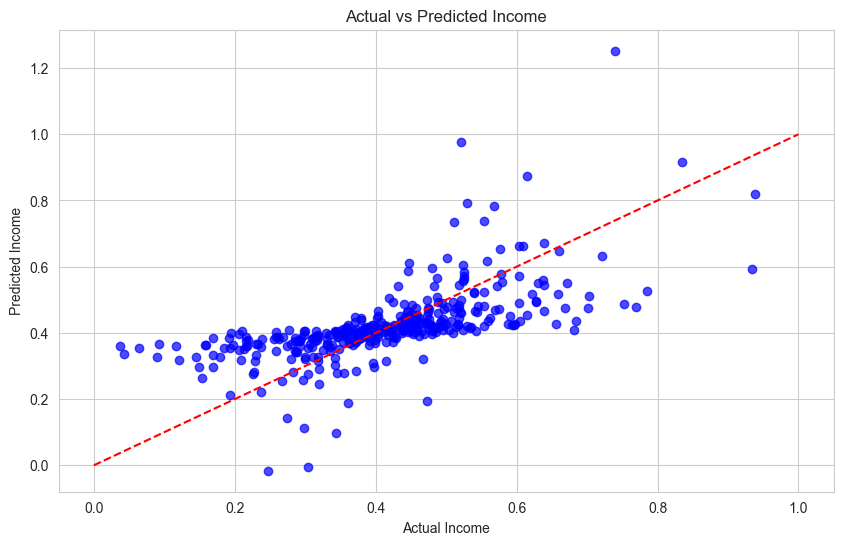

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income')
plt.show()

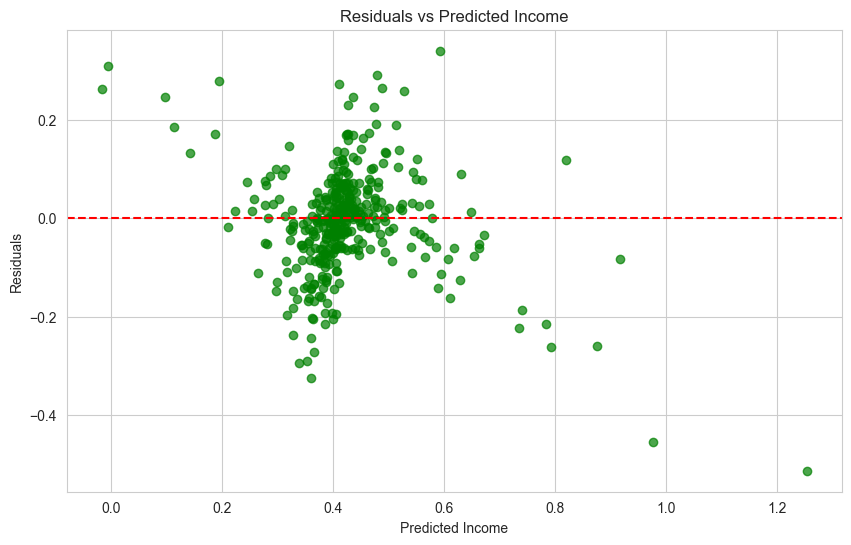

In [64]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='g')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Income')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Income')
plt.show()

In [22]:
# another try
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [65]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

Mean Squared Error: 0.006761192819294633
R^2 Score: 0.6436705248857413
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


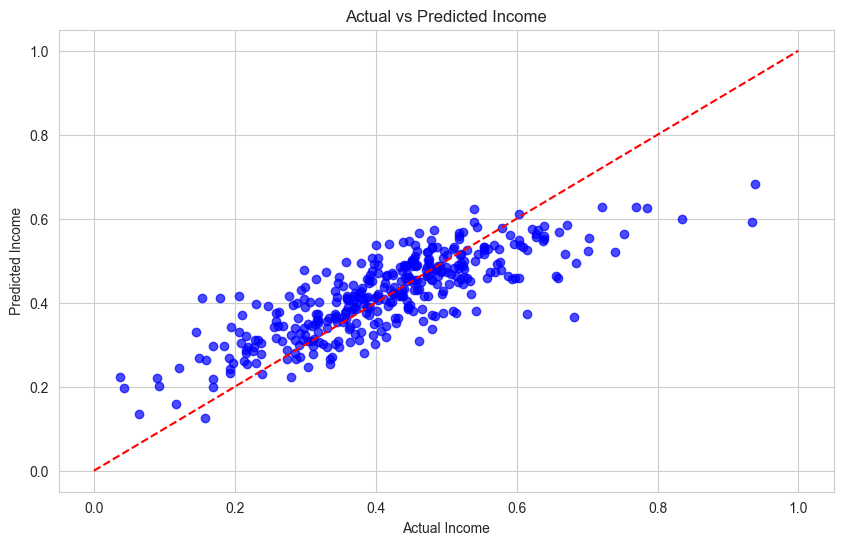

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income')
plt.show()

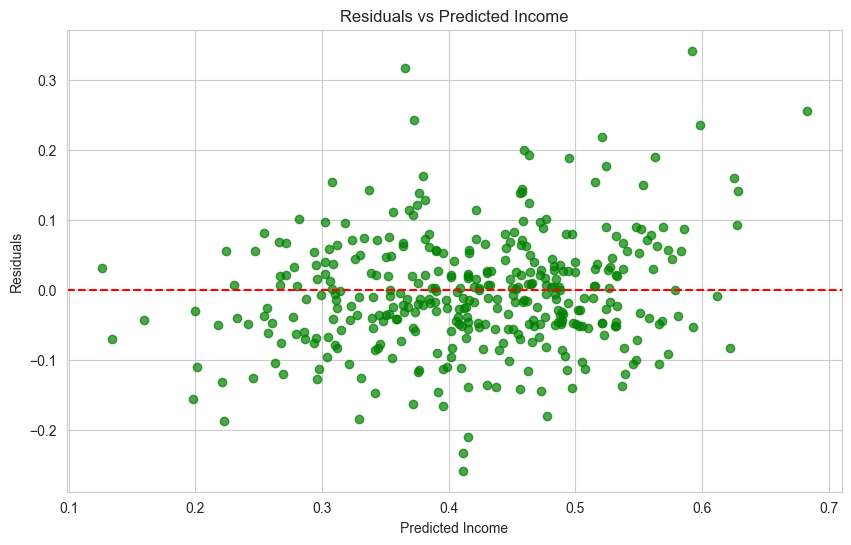

In [67]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='g')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Income')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Income')
plt.show()